<a href="https://colab.research.google.com/github/rnklee/ultrasound-nerve-segmentation/blob/main/nerve_segmentation_practice_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir
! pip install torcheval
! pip install scikit-image
! pip install ipympl

In [2]:
import sys, os
import re
import time
import pickle

In [3]:
from tqdm import tqdm

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from skimage.metrics import structural_similarity as ssim

from PIL import Image
import cv2

import random

from itertools import combinations

from collections import OrderedDict
from functools import partial

import pdb

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple

from torch.utils.data import Dataset, DataLoader, sampler

import torchvision
from torchvision import transforms, models

import segmentation_models_pytorch as smp
import albumentations

import segmentation_models_pytorch.utils.metrics
import segmentation_models_pytorch.utils.losses

# Load data from GitHub

In [ ]:
!git clone https://github.com/rnklee/ultrasound-nerve-segmentation

In [ ]:
%cd ultrasound-nerve-segmentation

In [10]:
ultrasoundpath = '.'
trainpath = './train'
datapath = './data'
modelspath = './models'

In [11]:
with open(datapath + '/cleaned_masks.pkl', 'rb') as f:
    masks = pickle.load(f)
with open(datapath + '/cleaned_images.pkl', 'rb') as f:
    images = pickle.load(f)
with open(datapath + '/cleaned_strat.pkl', 'rb') as f:
    stratify = pickle.load(f)

In [12]:
masks = [o.replace('/content/drive/MyDrive/ultrasound-nerve-segmentation/train', '') for o in masks]
images = [o.replace('/content/drive/MyDrive/ultrasound-nerve-segmentation/train', '') for o in images]

In [13]:
with open(datapath + '/train_test_msks.pkl', 'rb') as f:
    train_test_msks = pickle.load(f)
with open(datapath + '/train_test_stratify.pkl', 'rb') as f:
    train_test_stratify = pickle.load(f)
with open(datapath + '/test_msks.pkl', 'rb') as f:
    test_msks = pickle.load(f)
with open(datapath + '/train_msks.pkl', 'rb') as f:
    train_msks = pickle.load(f)
with open(datapath + '/valid_msks.pkl', 'rb') as f:
    valid_msks = pickle.load(f)

In [ ]:
# !git config --global user.email "rnklee@terpmail.umd.edu"
# !git config --global user.name "Rachel"
# !git add --all
# !git commit -m 'Implemented combination model'
# !git push 'https://MY_TOKEN@github.com/rnklee/ultrasound-nerve-segmentation.git'

# Basic exploratory data analysis

We begin by checking the size of the dataset and the shape of each image.

In [ ]:
len(masks)

5635

In [ ]:
cv2.imread(images[0], cv2.IMREAD_GRAYSCALE).shape

(420, 580)

Also make sure the images look OK.

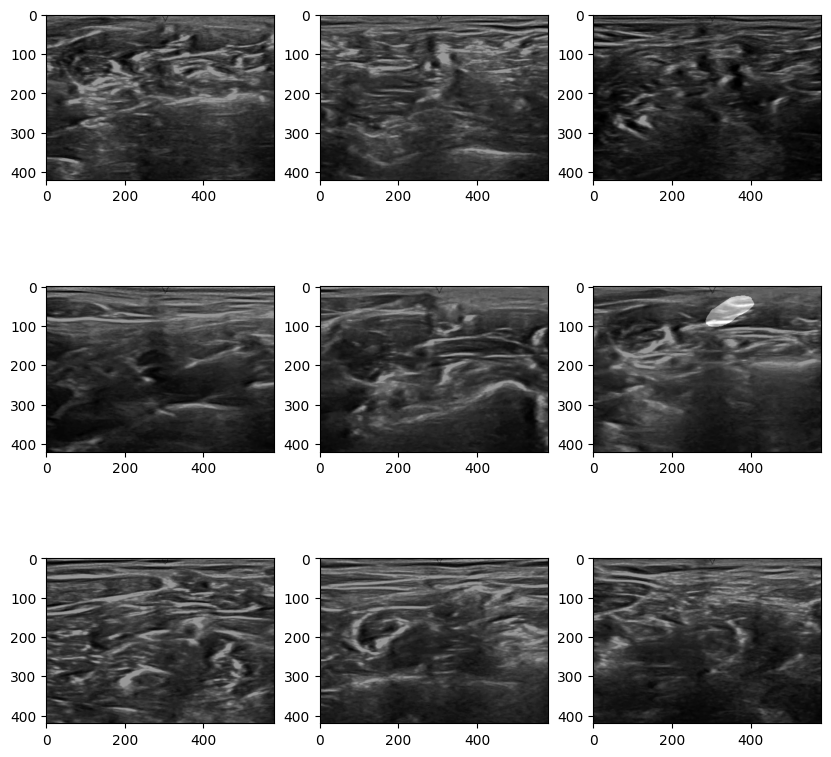

In [ ]:
rows, cols = 3, 3
fig = plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    ii = random.randint(0, len(images))
    fig.add_subplot(rows,cols,i)
    img_path = images[ii]
    msk_path = masks[ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray')
    plt.imshow(np.array(Image.open(msk_path)), alpha=0.4, cmap = 'gray')
plt.show()

## Removing duplicates
It was brought up in several Kaggle/blog posts that there are inconsistencies in masks. To resolve this, after finding pairs of images that are similar, I remove an image when its mask does not contain any nerve while its counterpart's mask does ([source](https://www.kaggle.com/code/agalea91/mislabeled-training-images/notebook)). Unlike the source, I use ssim on scaled images to determine whether two images are similar enough (as in this [article](https://medium.com/analytics-vidhya/ultrasound-nerve-segmentation-an-end-to-end-image-segmentation-case-study-ec88bfed0894)). The resulting datasets (consisting of 5496 images) are saved in data folder.

In [ ]:
def find_duplicates(images, masks):
    pairs = []

    msks = []
    imgs = []
    for i in tqdm(range(len(masks))):
        msks.append(cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE))
        imgs.append(cv2.imread(images[i], cv2.IMREAD_GRAYSCALE))

    for i in tqdm(range(len(masks))):
        msk1 = msks[i]
        img1 = cv2.resize(imgs[i], (64,64))
        for j in range(i+1, len(masks)):
            msk2 = msks[j]
            img2 = cv2.resize(imgs[j], (64,64))

            sim = ssim(img1, img2)
            if abs(sim) > 0.99 and msk1.any() != msk2.any():
                pairs.append((i,j))
    return pairs

In [ ]:
dup_pairs = find_duplicates(images, masks)

100%|██████████| 5635/5635 [2:41:47<00:00,  1.72s/it]


In [ ]:
to_remove = []
for pair in tqdm(dup_pairs):
    i1, i2 = pair
    msk1 = cv2.imread(masks[i1], cv2.IMREAD_GRAYSCALE)
    if msk1.any():
        to_remove.append(masks[i1])
    else:
        to_remove.append(masks[i2])
to_remove = list(set(to_remove))

100%|██████████| 262/262 [03:17<00:00,  1.33it/s]


# Create train/validation/test set

Since I only have limited amount of compute units, I decided to experiment with a small subset of the original dataset. These datasets are saved in data folder.[link text](https://)

In [ ]:
stratify = [has_nerve(o) for o in masks]
_, train_test_msks = train_test_split(masks, test_size = 0.3, stratify=stratify)
train_test_stratify = [has_nerve(o) for o in train_test_msks]
train_msks, test_msks = train_test_split(train_test_msks, test_size = 0.15, stratify=train_test_stratify)
train_stratify = [has_nerve(o) for o in train_msks]
train_msks, valid_msks = train_test_split(train_msks, test_size = 0.15, stratify=train_stratify)

In [ ]:
len(masks), len(train_test_msks), len(train_msks), len(valid_msks)

(5496, 1649, 1190, 211)

## Mask sizes/distribution

Check the mask sizes/distribution in the newly created dataset.

In [20]:
def has_nerve(mask):
    o = cv2.imread(trainpath+mask, cv2.IMREAD_GRAYSCALE)
    return 1 if o.any() else 0

In [ ]:
sum(stratify)/len(stratify)

0.39737991266375544

In [ ]:
mask_sizes = []
for o in train_msks:
    msk = cv2.imread(trainpath+o, cv2.IMREAD_GRAYSCALE)/255
    mask_sizes.append(msk.sum())

w, h = msk.shape

In [ ]:
mask_sizes = np.array(mask_sizes)

In [ ]:
len(np.where(mask_sizes>0)[0])/len(train_msks)

0.39663865546218485

In [ ]:
sum([1 if has_nerve(o) else 0 for o in train_msks])/len(train_msks)

0.39663865546218485

In [ ]:
nerve_i = np.where(mask_sizes>0)
np.mean(mask_sizes[nerve_i]/(w*h)), np.std(mask_sizes[nerve_i]/(w*h))

(0.029280513345022404, 0.0074315059530314495)

# Useful definitions

In [96]:
def has_nerve(mask):
    o = cv2.imread(trainpath+mask, cv2.IMREAD_GRAYSCALE)
    return 1 if o.any() else 0

In [25]:
def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32')

## Simpler ResNet-UNet
ResNet encoder implementation adopted from https://github.com/FrancescoSaverioZuppichini/ResNet. Decoder implementation adopted from [smp implementaion of UNet](https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch/decoders/unet).

In [28]:
class Conv2dAuto(nn.Conv2d):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.padding = (self.kernel_size[0]//2, self.kernel_size[1]//2)


def conv_bn(inplanes, planes, kernel_size=3, stride=1, *args, **kwargs):
    conv = partial(Conv2dAuto, kernel_size=kernel_size, stride=stride, bias=False)
    return nn.Sequential(OrderedDict(
        {
            'conv' : conv(inplanes, planes, *args, **kwargs),
            'bn' : nn.BatchNorm2d(planes)
        }
    ))


conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

In [29]:
class ResNetBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, expansion=1, downsampling=1, *args, **kwargs):
        super().__init__()
        self.inplanes, self.planes = inplanes, planes
        self.expansion, self.downsampling = expansion, downsampling

        self.blocks = nn.Identity()
        self.shortcut = nn.Sequential(OrderedDict(
            {
                'conv_bn' : conv_bn(self.inplanes, self.expansion * self.planes, kernel_size=1, stride=self.downsampling)
            }
        )) if self.inplanes != self.expansion * self.planes else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x



class ResNetBasicBlock(ResNetBlock):
    def __init__(self, inplanes, planes, kernel_size=3, activation=nn.ReLU, *args, **kwargs):
        super().__init__(inplanes, planes, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.inplanes, self.planes, kernel_size=kernel_size, stride=self.downsampling),
            activation(),
            conv_bn(self.planes, self.expansion * self.planes, kernel_size=kernel_size)
        )



class ResNetBottleneckBlock(ResNetBlock):
    expansion = 4
    def __init__(self, inplanes, planes, kernel_size=3, activation=nn.ReLU, *args, **kwargs):
        super().__init__(inplanes, planes, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.inplanes, self.planes, kernel_size=1),
            activation(),
            conv_bn(self.planes, self.planes, kernel_size=kernel_size, stride=self.downsampling),
            activation(),
            conv_bn(self.planes, self.expansion * self.planes, kernel_size=1)
        )



class ResNetLayer(nn.Module):
    def __init__(self, inplanes, planes, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        self.downsampling = 2 if inplanes != planes else 1

        self.blocks = nn.Sequential(
            block(inplanes, planes, *args, **kwargs, downsampling=self.downsampling),
            *[block(block.expansion * planes, block.expansion * planes, downsamplig=1, *args, **kwargs) for _ in range(n-1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x



class ResNetEncoder(nn.Module):
    # no stem if stem_size=0
    def __init__(self, inplanes=3, stem_size=64, block_sizes=[64,128,256,512], depths=[2,2,2,2],
                 activation=nn.ReLU, block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.out_channels = [stem_size] + block_sizes if stem_size else block_sizes

        if stem_size:
            self.stem = nn.Sequential(
                conv_bn(inplanes, stem_size, kernel_size=7, stride=2),
                activation(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
            inplanes = stem_size

        else:
            self.stem = nn.Identity()

        in_out_planes = list(zip(block_sizes[:-1], block_sizes[1:]))
        self.layers = nn.ModuleList([
            ResNetLayer(inplanes, block_sizes[0], n=depths[0], activation=activation, block=block, *args, **kwargs),
            *[ResNetLayer(inplanes*block.expansion, planes, n=n, activation=activation, block=block, *args, **kwargs)
            for (inplanes, planes), n in zip(in_out_planes, depths[1:])]
        ])

        downsampling = [layer.downsampling for layer in self.layers]
        self.downsampling = [4] + downsampling if stem_size else downsampling


    def forward(self, x):
        x = self.stem(x)
        outputs = [x]
        for layer in self.layers:
            x = layer(x)
            outputs = [x] + outputs
        return outputs

In [30]:
# UNet implementation adopted from smp source code.
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, skip_channel, out_channel):
        super().__init__()
        self.in_channel, self.skip_channel, self.out_channel = in_channel, skip_channel, out_channel
        self.blocks = nn.Sequential(
            conv_bn(in_channel + skip_channel, out_channel),
            conv_bn(out_channel, out_channel)
        )

    def forward(self, x, skip=None, scale_factor=1):
        if self.skip_channel:
            scale_factor = skip.shape[2]//x.shape[2]
            x = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
            x = torch.cat([x, skip], dim=1)
        else:
            x = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
        x = self.blocks(x)
        return x



class UNetDecoder(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()

        skip_channels = list(encoder_channels[1:]+[0])
        in_channels = decoder_channels[:-1]
        out_channels = decoder_channels[1:]
        blocks = [
            DecoderBlock(in_channel, skip_channel, out_channel)
            for in_channel, skip_channel, out_channel in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):
        x = features[0]
        skips = features[1:]
        for i, decoder_block in enumerate(self.blocks):
            if i < len(skips):
                x = decoder_block(x, skip=skips[i])
            else:
                x = decoder_block(x, skip=None, scale_factor=4)
        return x

In [31]:
class UNet(nn.Module):
    def __init__(self, encoder, activation=nn.Sigmoid, postprocessing=nn.Identity):
        super().__init__()

        self.encoder = encoder

        # For this simplified decoder, just assume decoder reduces the channels by two at all layers,
        # with the last layer outputting 16 channels.
        encoder_channels = encoder.out_channels[::-1]
        decoder_channels = [encoder_channels[0]//(2**i) for i in range(len(encoder_channels)+1)]
        self.decoder = UNetDecoder(encoder_channels, decoder_channels)
        self.segmentation_head = nn.Sequential(OrderedDict(
            {
                'conv_bn':  conv_bn(decoder_channels[-1], 1),
                'activation': activation(),
                'post-processing': postprocessing()
            }
        ))


    def forward(self, x):
        features = self.encoder(x)
        decoder_output = self.decoder(*features)
        masks = self.segmentation_head(decoder_output)

        return masks

In [32]:
scratch_resnet = ResNetEncoder(inplanes=1, stem_size=64, block_sizes=[64,128,256,512], depths=[2,2,2,2], activation=nn.ReLU, block=ResNetBasicBlock)
scratch_model = UNet(encoder=scratch_resnet)
scratch_model

UNet(
  (encoder): ResNetEncoder(
    (stem): Sequential(
      (0): Sequential(
        (conv): Conv2dAuto(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layers): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-

## Segmentation loss functions

reference: https://ieeexplore.ieee.org/document/9277638.

In [21]:
class DiceLoss(nn.Module):
    def __init__(self, soft=True, smooth=1e-7, reduce=torch.mean):
        super().__init__()
        self.soft = soft
        self.smooth = smooth
        self.reduce = reduce
        self.__name__ = 'soft_dice' if soft else 'hard_dice'

    def forward(self, output, target):
        dims = (1,2,3)
        if not self.soft:
            target = torch.round(target)
        intersection = torch.sum(output*target, dims)
        union = torch.sum(output+target, dims)

        loss = 1 - (2*intersection + self.smooth)/(union + self.smooth)
        if self.reduce is not None:
            return self.reduce(loss)
        else: return loss

In [22]:
class BCELoss(nn.Module):
    def __init__(self, weights=(1,1), reduce=torch.mean):
        super().__init__()
        self.weights = weights
        self.reduce = reduce
        self.__name__ = 'bce'

    def forward(self, output, target):
        output = torch.clamp(output, min=-100)
        log0, log1 = torch.log(output), torch.log(1-output)
        log0[torch.isinf(log0)] = -100
        log1[torch.isinf(log1)] = -100

        loss = self.weights[0]*target*log0 + self.weights[1]*(1-target)*log1
        return self.reduce(-loss)

In [23]:
class ComboLoss(nn.Module):
    """
    alpha: alpha*BCE + (1-alpha)*Dice
    beta: the weight for BCE loss
    """
    def __init__(self, alpha=0.5, beta=(1,1), soft=False):
        super().__init__()
        self.__name__ = 'BCE_soft_dice' if soft else 'BCE_hard_dice'
        self.alpha = alpha
        self.beta = beta
        self.soft = soft

    def forward(self, output, target):
        bce = BCELoss(weights=self.beta)
        dice = DiceLoss(self.soft)
        return self.alpha*bce(output, target) + (1-self.alpha)*dice(output, target)

In [24]:
class FocalLoss(nn.Module):
    """
    -alpha_t(1-p_t)^gamma log(p_t)
    when gamma=1, Focal loss works like CE loss.
    """
    def __init__(self, alpha=0.5, gamma=1, reduce=torch.mean):
        self.__name__ = 'focal'
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, output, target):
        bce_loss = nn.BCELoss()(output, target)
        p_t = target*output + (1-target)*(1-output)
        alpha_t = target*1 + (1-target)*self.alpha
        loss = alpha_t * (1-p_t)**self.gamma * bce_loss
        return self.reduce(loss)

## More definitions


In [26]:
class NerveDataset(Dataset):
    def __init__(self, mskfiles, color=True, preprocess=None, augment=None, train=True):
        super().__init__()

        self.mskfiles = [trainpath+o for o in mskfiles]
        self.imgfiles = [o.replace('_mask', '') for o in self.mskfiles]

        self.preprocess = preprocess
        self.augment = augment
        self.color = color


    def __len__(self):
        return len(self.mskfiles)


    def __getitem__(self, idx):
        if self.color:
            img = cv2.imread(self.imgfiles[idx])
        else:
            img = cv2.imread(self.imgfiles[idx], cv2.IMREAD_GRAYSCALE)

        msk = cv2.imread(self.mskfiles[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment is not None:
            sample = self.augment(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if self.preprocess is not None:
            sample = self.preprocess(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if not self.color:
            img = np.expand_dims(img, axis=0)
        img = img.astype(np.float32)
        msk = (msk/255).astype(np.float32)
        msk = np.expand_dims(msk, axis=0)

        return img, msk

In [27]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.03):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        return False

The codes below are borrowed from https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch/utils with minor modifications.



In [28]:
class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass


class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [29]:
class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                #batch_size = x.shape[0]
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs



class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        #prediction = self.model.forward(x)
        prediction = self.model(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            #prediction = self.model.forward(x)
            prediction = self.model(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [30]:
def train_validate(train_msks, valid_msks, preprocess, augment, model, optim,
                   color=True, loss=DiceLoss(soft=True), metrics=[DiceLoss(soft=True), DiceLoss(soft=False)],
                   device='cuda', batch_size=16, epochs=5,
                   save_thres=1e6, save_metric='hard_dice', save_path=None, stop_early=False):

    valid_nerves = np.array([has_nerve(o) for o in valid_msks])
    valid_no_nerves, valid_nerves = np.where(valid_nerves==0), np.where(valid_nerves>0)
    nerve_ratio = len(valid_nerves[0])/len(valid_msks)
    print(f'{len(valid_msks)} samples in validation set: {len(valid_nerves[0])} with nerves {len(valid_no_nerves[0])} with no nerve.')
    print(f'Ratio of samples with nerves in validation set: {nerve_ratio}')
    valid_msks0, valid_msks1 = np.array(valid_msks)[valid_no_nerves], np.array(valid_msks)[valid_nerves]

    traindata = NerveDataset(mskfiles=train_msks, color=color, preprocess=preprocess, augment=augment)
    validdata0 = NerveDataset(mskfiles=valid_msks0, color=color, preprocess=preprocess)
    validdata1 = NerveDataset(mskfiles=valid_msks1, color=color, preprocess=preprocess)
    validdata = NerveDataset(mskfiles=valid_msks, color=color, preprocess=preprocess)

    trainloader = DataLoader(traindata, batch_size = batch_size, shuffle = True)
    validloader0 = DataLoader(validdata0, batch_size = 1)
    validloader1 = DataLoader(validdata1, batch_size = 1)
    validloader = DataLoader(validdata, batch_size = 1)

    trainepoch = TrainEpoch(model, optimizer=optim, device=device, loss=loss, metrics=metrics)
    validepoch = ValidEpoch(model, device=device, loss=loss, metrics=metrics)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

    if stop_early:
        stopper = EarlyStopper()

    columns = ['epoch', 'type'] + [metric.__name__ for metric in metrics]
    loss_log = pd.DataFrame(columns=columns)
    for i in range(epochs):
        print('\nEpoch: {}'.format(i))
        trainlogs = trainepoch.run(trainloader)
        validlogs0 = validepoch.run(validloader0)
        validlogs1 = validepoch.run(validloader1)
        validlogs = validepoch.run(validloader)

        train_loss = {'epoch': i, 'type': 'train'}
        valid_loss0 = {'epoch': i, 'type': 'valid_no_nerve'}
        valid_loss1 = {'epoch': i, 'type': 'valid_nerve'}
        valid_loss = {'epoch': i, 'type': 'valid'}

        train_loss.update(dict([(metric.__name__, trainlogs[metric.__name__]) for metric in metrics]))
        valid_loss0.update(dict([(metric.__name__, validlogs0[metric.__name__]) for metric in metrics]))
        valid_loss1.update(dict([(metric.__name__, validlogs1[metric.__name__]) for metric in metrics]))
        valid_loss.update(dict([(metric.__name__, validlogs[metric.__name__]) for metric in metrics]))

        loss_log.loc[len(loss_log)] = train_loss
        loss_log.loc[len(loss_log)] = valid_loss0
        loss_log.loc[len(loss_log)] = valid_loss1
        loss_log.loc[len(loss_log)] = valid_loss

        save_loss = validlogs[save_metric]
        if save_path is not None and save_metric < save_thres:
            save_thres = save_metric
            torch.save(model, save_path)

        if stop_early:
            if stopper.early_stop(valid_loss[save_metric]):
                print('Early stop triggered.')
                break
            print(f'Valid Loss: {valid_loss[save_metric]:.4}, Stopper: min_validation_loss {stopper.min_validation_loss:.4}, counter {stopper.counter}.')

        lr_scheduler.step()

    return loss_log



def split_train_validate(mskfiles, augment, preprocess, model, optim,
                         color=True, loss=DiceLoss(), metrics=[DiceLoss(), DiceLoss(soft=False)],
                         device='cuda', batch_size=16, epochs=5, val_size=0.15,
                         save_thres=1e6, save_metric='hard_dice', save_path=None, stop_early=False):

    stratify = [has_nerve(o) for o in mskfiles]
    train_msks, valid_msks = train_test_split(mskfiles, test_size=val_size, stratify=stratify)
    train_valid_log = train_validate(train_msks, valid_msks, preprocess, augment, model, optim,
                                     color, loss, metrics,
                                     device, batch_size, epochs,
                                     save_thres, save_metric, save_path, stop_early)
    return train_valid_log


In [31]:
def predict_compare(mskfiles, model, color=True, preprocess=None, metrics=[DiceLoss(soft=True), DiceLoss(soft=False)], device='cuda'):
    if isinstance(model, str):
        test_model = torch.load(model)
    else: test_model = model
    test_data = NerveDataset(mskfiles=mskfiles, color=True, preprocess=preprocess)
    test_loader = DataLoader(test_data, batch_size=1) # DataLoader probably unnecessary here. Still a good practice?

    columns = [metric.__name__ for metric in metrics] + ['gt_mask_size', 'pred_mask_size']
    test_log = pd.DataFrame(columns=columns)
    with tqdm(
        test_loader,
        disable=False
    ) as iterator:
        for x, y in iterator:
            x, y = x.to(device), y.to(device)

            with torch.no_grad():
                pred = test_model(x)

            # update the log
            log_update = {metric.__name__: metric(y, pred).item() for metric in metrics}
            log_update.update({'gt_mask_size': y.sum().item(), 'pred_mask_size': pred.round().sum().item()})
            test_log.loc[len(test_log)] = log_update

    return test_log

In [32]:
def plot_train_validate(log, ax):
    xticks = range(log['epoch'].max() + 1)
    for type, df in log.groupby('type'):
        df.plot(x='epoch', y='hard_dice', ax=ax, label=type, xticks=xticks);
    plt.legend()

In [33]:
def load_train_config():
    return {'train_msks': train_msks,
            'valid_msks': valid_msks,
            'augment': albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                                albumentations.HorizontalFlip()]),
            'loss': DiceLoss(),
            'metrics': [DiceLoss(), DiceLoss(soft=False)],
            'device': 'cuda',
            'batch_size': 16,
            'epochs': 30,
            'save_thres': 1e6, 'save_metric': 'hard_dice', 'save_path': None,
            'stop_early': False
            }

# Segmentation: first attempt

## UNet with pre-trained ResNet34

### With Dice Loss

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

resnet34_imagenet_model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
optim = torch.optim.Adam([dict(params=resnet34_imagenet_model.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()

resnet34_imagenet_log = train_validate(preprocess=preprocess, model=resnet34_imagenet_model, optim=optim, **config)

211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:05<00:00, 37.29it/s, soft_dice - 0.9618, hard_dice - 0.9618]

Epoch: 1
valid: 100%|██████████| 211/211 [00:04<00:00, 42.73it/s, soft_dice - 0.7382, hard_dice - 0.7382]

Epoch: 2
valid: 100%|██████████| 211/211 [00:05<00:00, 36.32it/s, soft_dice - 0.7318, hard_dice - 0.7318]

Epoch: 3
valid: 100%|██████████| 211/211 [00:04<00:00, 43.37it/s, soft_dice - 0.7074, hard_dice - 0.7074]

Epoch: 4
valid: 100%|██████████| 211/211 [00:04<00:00, 44.61it/s, soft_dice - 0.6986, hard_dice - 0.6986]

Epoch: 5
valid: 100%|██████████| 211/211 [00:04<00:00, 44.90it/s, soft_dice - 0.7007, hard_dice - 0.7007]

Epoch: 6
valid: 100%|██████████| 211/211 [00:04<00:00, 44.01it/s, soft_dice - 0.6892, hard_dice - 0.6892]

Epoch: 7
valid: 100%|██████████| 211/211 [00:04<00:00, 44.12it/s, soft_dice - 0.7027, hard_dice - 0.7027]

Epoch: 8
va

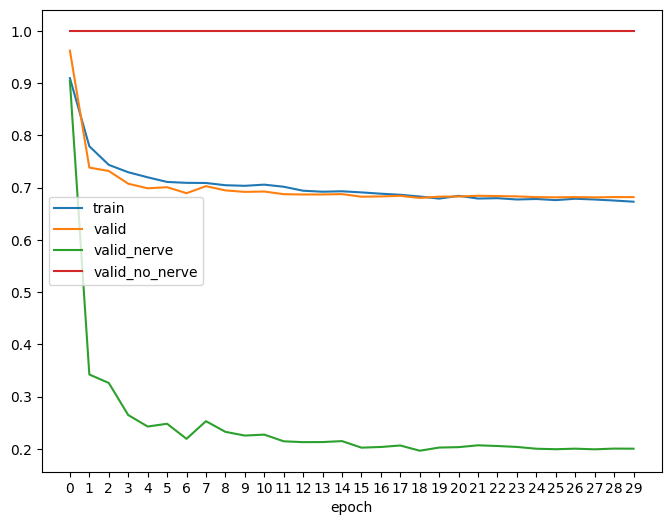

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plot_train_validate(resnet34_imagenet_log, ax)

In [ ]:
resnet34_imagenet_pred = predict_compare(valid_msks,
                                         resnet34_imagenet_model,
                                         color=True,
                                         preprocess=preprocess,
                                         metrics=[DiceLoss(), DiceLoss(soft=False)])

100%|██████████| 211/211 [00:04<00:00, 44.19it/s]


<Axes: xlabel='gt_mask_size', ylabel='pred_mask_size'>

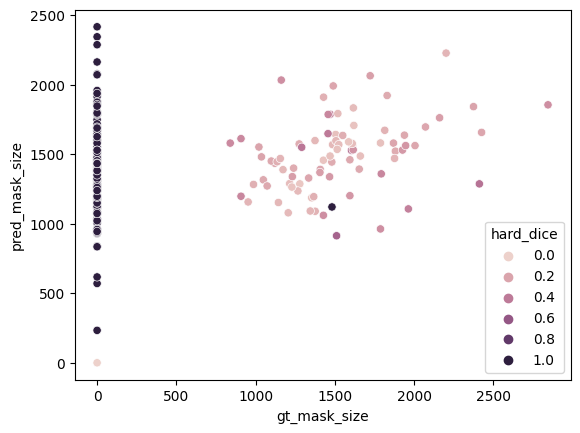

In [ ]:
sns.scatterplot(data=resnet34_imagenet_pred, x='gt_mask_size', y='pred_mask_size', hue='hard_dice')

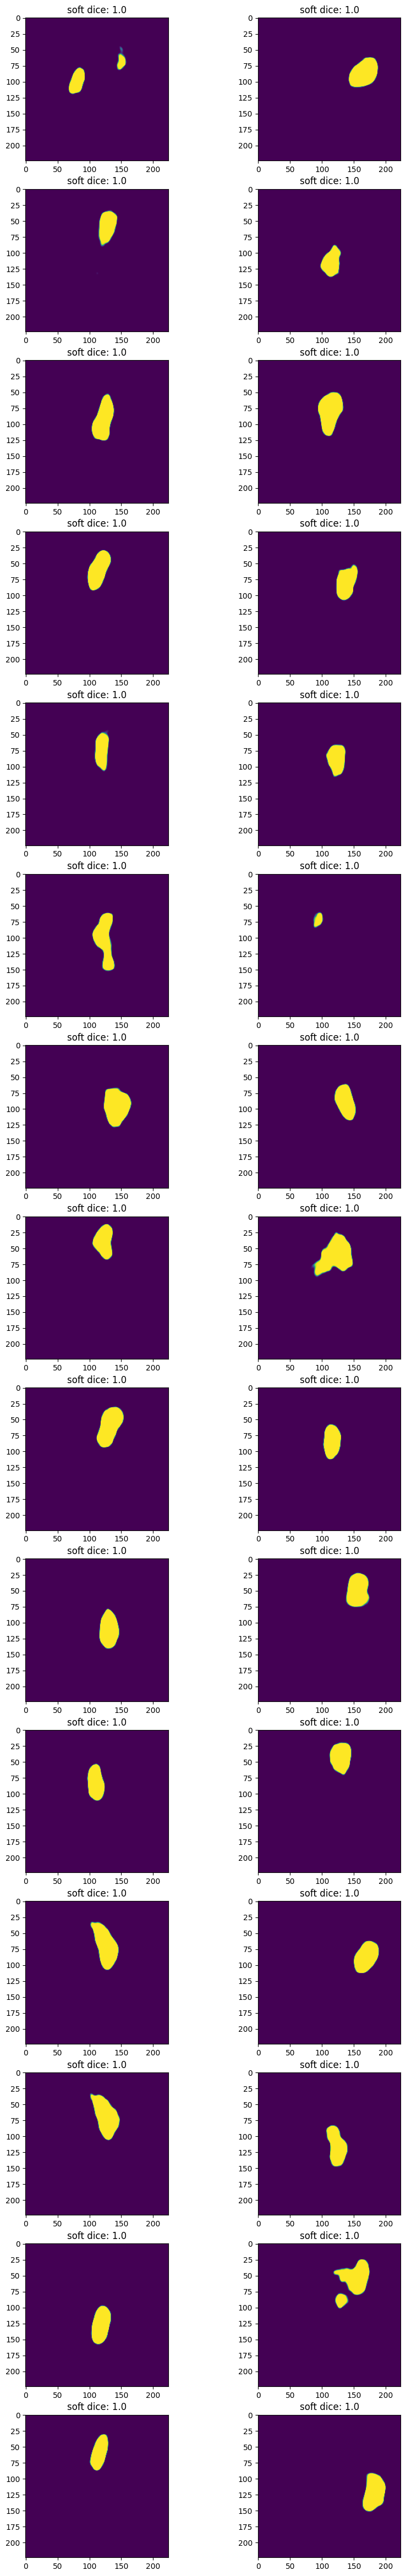

In [83]:
rows, cols = 15, 2
fig = plt.figure(figsize=(10, 60))
fig.tight_layout(pad=10.0)

valid_nerves = np.array([has_nerve(o) for o in valid_msks])
valid_msks0 = np.array(valid_msks)[np.where(valid_nerves==0)]

test_data = NerveDataset(mskfiles=valid_msks0, color=True, preprocess=preprocess)
test_log = pd.Dataframe([])
for i in range(len(test_data)):
    fig.add_subplot(rows, cols, i)

    x, y = test_data[i]
    x, y = torch.from_numpy(x).to('cuda').unsqueeze(0), torch.from_numpy(y).to('cuda').unsqueeze(0)

    with torch.no_grad():
        pred = resnet34_imagenet_model(x)
        soft_dice = DiceLoss()(y, pred)

    x, y, pred = x.cpu().squeeze().numpy(), y.cpu().squeeze().numpy(), pred.squeeze().cpu().detach().numpy()

    plt.imshow(pred);
    plt.title(f'soft dice: {soft_dice:.3}')

### With BCE Loss

In [93]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

resnet34_imagement_model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
optim = torch.optim.Adam([dict(params=resnet34_imagenet_model.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()
config['loss'] = BCELoss()
config['metrics'] += [BCELoss()]
config['epochs'] = 20

resnet34_bce_log = train_validate(preprocess=preprocess, model=resnet34_imagenet_model, optim=optim, **config)

211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 53.34it/s, bce - 0.02875, soft_dice - 0.8389, hard_dice - 0.8389]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 53.59it/s, bce - 0.02994, soft_dice - 0.8043, hard_dice - 0.8043]

Epoch: 2
valid: 100%|██████████| 211/211 [00:04<00:00, 49.78it/s, bce - 0.02602, soft_dice - 0.829, hard_dice - 0.829]

Epoch: 3
valid: 100%|██████████| 211/211 [00:03<00:00, 53.05it/s, bce - 0.02645, soft_dice - 0.7849, hard_dice - 0.7849]

Epoch: 4
valid: 100%|██████████| 211/211 [00:04<00:00, 52.06it/s, bce - 0.02441, soft_dice - 0.7826, hard_dice - 0.7826]

Epoch: 5
valid: 100%|██████████| 211/211 [00:03<00:00, 53.57it/s, bce - 0.02395, soft_dice - 0.7857, hard_dice - 0.7857]

Epoch: 6
valid: 100%|██████████| 211/211 [00:03<00:00, 53.94it/s, bce - 0.02439, soft_dice - 0.793, hard_dice - 0.793]

Epoch: 7
valid: 1

## With freezing and BCE Loss

In [97]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

resnet34_imagenet_decoder_model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)

for i, child in enumerate(resnet34_imagenet_decoder_model.encoder.children()):
    for param in child.parameters():
        param.requires_grad = False

optim = torch.optim.Adam([dict(params=resnet34_imagenet_decoder_model.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()
config['loss'] = BCELoss()
config['metrics'] += [BCELoss()]
config['epochs'] = 10

restnet34_imagenet_decoder_log = train_validate(preprocess=preprocess, model=resnet34_imagenet_decoder_model, optim=optim, **config)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 17.8MB/s]


211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 57.66it/s, bce - 0.09679, soft_dice - 0.9833, hard_dice - 0.9833]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 58.31it/s, bce - 0.06217, soft_dice - 0.9732, hard_dice - 0.9732]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 58.38it/s, bce - 0.04816, soft_dice - 0.9022, hard_dice - 0.9022]

Epoch: 3
valid: 100%|██████████| 211/211 [00:04<00:00, 47.44it/s, bce - 0.03828, soft_dice - 0.8513, hard_dice - 0.8513]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 58.00it/s, bce - 0.03592, soft_dice - 0.8883, hard_dice - 0.8883]

Epoch: 5
valid: 100%|██████████| 211/211 [00:03<00:00, 58.97it/s, bce - 0.03811, soft_dice - 0.8324, hard_dice - 0.8324]

Epoch: 6
valid: 100%|██████████| 211/211 [00:04<00:00, 52.31it/s, bce - 0.03002, soft_dice - 0.8103, hard_dice - 0.8103]

Epoch: 7
vali

# Simpler UNet model


In [34]:
scratch_resnet = ResNetEncoder(inplanes=1, stem_size=64, block_sizes=[64,128,256,512], depths=[2,2,2,2], activation=nn.ReLU, block=ResNetBasicBlock)
scratch_model = UNet(encoder=scratch_resnet)
scratch_model

optim = torch.optim.Adam([dict(params=scratch_model.parameters(), lr=3e-3)])

preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR)])

config = load_train_config()
config['preprocess'] = preprocess
config['color'] = False

scratch_log = train_validate(model=scratch_model, optim=optim, **config)

211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:02<00:00, 83.22it/s, soft_dice - 0.9664, hard_dice - 0.9664]

Epoch: 1
valid: 100%|██████████| 211/211 [00:02<00:00, 84.57it/s, soft_dice - 0.9543, hard_dice - 0.9543]

Epoch: 2
valid: 100%|██████████| 211/211 [00:02<00:00, 85.46it/s, soft_dice - 0.8329, hard_dice - 0.8329]

Epoch: 3
valid: 100%|██████████| 211/211 [00:02<00:00, 88.39it/s, soft_dice - 0.9267, hard_dice - 0.9267]

Epoch: 4
valid: 100%|██████████| 211/211 [00:02<00:00, 86.20it/s, soft_dice - 0.962, hard_dice - 0.962]

Epoch: 5
valid: 100%|██████████| 211/211 [00:02<00:00, 71.93it/s, soft_dice - 0.795, hard_dice - 0.795]

Epoch: 6
valid: 100%|██████████| 211/211 [00:03<00:00, 69.37it/s, soft_dice - 0.9521, hard_dice - 0.9521]

Epoch: 7
valid: 100%|██████████| 211/211 [00:02<00:00, 85.15it/s, soft_dice - 0.8555, hard_dice - 0.8555]

Epoch: 8
valid:

# Combining classification with segmentation

The average Dice loss for images with nerves is approximately 0.2. For now, let's assume that the distribution of the Dice loss on the validation samples with nerves is homogeneous, and the average won't change drastically on a subset (of a reasonable size). With this assumption, we can potentially improve the Dice loss to

<center>$\displaystyle
\frac{\text{tp}}{\text{all}}\cdot 0.2
+ \frac{\text{tn}}{\text{all}}\cdot 0
+ (1-\text{accuracy})\cdot 1$</center>

by combining a classification model with a segmentation model.



## Classification loss functions

In [35]:
from torchvision.models import resnet34, ResNet34_Weights

from torcheval.metrics import Cat, BinaryAccuracy, BinaryF1Score
from torcheval.metrics.functional import binary_accuracy, binary_precision, binary_recall, binary_f1_score

In [48]:
class BCELoss(nn.Module):
    def __init__(self, weights=(1,1), reduce=torch.mean):
        super().__init__()
        self.weights = weights
        self.reduce = reduce
        self.__name__ = 'bce'

    def forward(self, output, target):
        output = torch.clamp(output, min=-100)
        log0, log1 = torch.log(output), torch.log(1-output)
        log0[torch.isinf(log0)] = -100
        log1[torch.isinf(log1)] = -100

        loss = self.weights[0]*target*log0 + self.weights[1]*(1-target)*log1
        return self.reduce(-loss)


class ClassificationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.__name__ = None

    def forward(self, output, target):
        pass

    def counts(self, output, target):
        output = torch.round(output)
        tp = torch.sum(output*target, 1)
        tn = torch.sum((1-output)*(1-target), 1)
        fp = torch.sum(output*(1-target), 1)
        fn = torch.sum((1-output)*target, 1)
        return tp, tn, fp, fn



class Accuracy(ClassificationLoss):
    def __init__(self, epsilon = 1e-7):
        super().__init__()
        self.epsilon = epsilon
        self.__name__ = 'accuracy'

    def forward(self, output, target):
        tp, tn, fp, fn = self.counts(output, target)
        acc = (tp+tn) / (tp+fn+tn+fp + self.epsilon)
        return torch.mean(acc)



class Precision(ClassificationLoss):
    def __init__(self, epsilon = 1e-7):
        super().__init__()
        self.epsilon = epsilon
        self.__name__ = 'precision'

    def forward(self, output, target):
        tp, tn, fp, fn = self.counts(output, target)
        prec = tp / (tp+fp + self.epsilon)
        return torch.mean(prec)



class Recall(ClassificationLoss):
    def __init__(self, epsilon = 1e-7):
        super().__init__()
        self.epsilon = epsilon
        self.__name__ = 'recall'

    def forward(self, output, target):
        tp, tn, fp, fn = self.counts(output, target)
        rec = tp / (tp+fn + self.epsilon)
        return torch.mean(rec)



class F1Score(ClassificationLoss):
    def __init__(self, epsilon = 1e-7):
        super().__init__()
        self.epsilon = epsilon
        self.__name__ = 'f1'

    def forward(self, output, target):
        tp, tn, fp, fn = self.counts(output, target)
        f1 = 2*tp / (2*tp+fn+fp + self.epsilon)
        return torch.mean(f1)

## Other definitions

In [49]:
class ClassDataset(Dataset):
    def __init__(self, mskfiles, color=True, preprocess=None, augment=None, train=True):
        super().__init__()

        self.mskfiles = [trainpath+o for o in mskfiles]
        self.imgfiles = [o.replace('_mask', '') for o in self.mskfiles]

        self.preprocess = preprocess
        self.augment = augment
        self.color = color


    def __len__(self):
        return len(self.mskfiles)


    def __getitem__(self, idx):
        if self.color:
            img = cv2.imread(self.imgfiles[idx])
        else:
            img = cv2.imread(self.imgfiles[idx], cv2.IMREAD_GRAYSCALE)

        msk = cv2.imread(self.mskfiles[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment is not None:
            sample = self.augment(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if self.preprocess is not None:
            sample = self.preprocess(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if not self.color:
            img = np.expand_dims(img, axis=0)

        img = img.astype(np.float32)
        label = 1 if msk.any() else 0
        label = np.expand_dims(label, axis=0)

        return img, label

In [40]:
class ClassificationModel(nn.Module):
    def __init__(self, conv_model=torchvision.models.resnet34, conv_weights=ResNet34_Weights.DEFAULT, activation=nn.Sigmoid):
        super().__init__()
        self.conv_model = conv_model(weights=conv_weights)
        self.classification_head = nn.Sequential(OrderedDict(
            {
                'linear': nn.Linear(1000, 1, bias=True),
                'activation': activation()
            }
        ))

    def forward(self, x):
        features = self.conv_model(x)
        prob = self.classification_head(features)
        return prob

In [41]:
def classify_validate(train_msks, valid_msks, preprocess, augment, model, optim,
                   color=True, loss=DiceLoss(soft=True), metrics=[DiceLoss(soft=True), DiceLoss(soft=False)],
                   device='cuda', batch_size=16, epochs=5,
                   save_thres=1e6, save_metric='hard_dice', save_path=None, stop_early=False):

    traindata = ClassDataset(mskfiles=train_msks, color=color, preprocess=preprocess, augment=augment)
    validdata = ClassDataset(mskfiles=valid_msks, color=color, preprocess=preprocess)

    trainloader = DataLoader(traindata, batch_size = batch_size, shuffle = True)
    validloader = DataLoader(validdata, batch_size = 1)

    trainepoch = TrainEpoch(model, optimizer=optim, device=device, loss=loss, metrics=metrics)
    validepoch = ValidEpoch(model, device=device, loss=loss, metrics=metrics)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

    if stop_early:
        stopper = EarlyStopper()

    columns = ['epoch', 'type'] + [metric.__name__ for metric in metrics]
    loss_log = pd.DataFrame(columns=columns)
    for i in range(epochs):
        print('\nEpoch: {}'.format(i))
        trainlogs = trainepoch.run(trainloader)
        validlogs = validepoch.run(validloader)

        train_loss = {'epoch': i, 'type': 'train'}
        valid_loss = {'epoch': i, 'type': 'valid'}

        train_loss.update(dict([(metric.__name__, trainlogs[metric.__name__]) for metric in metrics]))
        valid_loss.update(dict([(metric.__name__, validlogs[metric.__name__]) for metric in metrics]))

        loss_log.loc[len(loss_log)] = train_loss
        loss_log.loc[len(loss_log)] = valid_loss

        save_loss = validlogs[save_metric]
        if save_path is not None and save_metric < save_thres:
            save_thres = save_metric
            torch.save(model, save_path)

        if stop_early:
            if stopper.early_stop(valid_loss[save_metric]):
                print('Early stop triggered.')
                break
            print(f'Valid Loss: {valid_loss[save_metric]:.4}, Stopper: min_validation_loss {stopper.min_validation_loss:.4}, counter {stopper.counter}.')

        lr_scheduler.step()

    return loss_log

In [61]:
def load_classify_config():
    return {
        'train_msks': train_msks,
        'valid_msks': valid_msks,
        'augment': albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                            albumentations.HorizontalFlip()]),
        'loss': BCELoss(),
        'metrics': [Accuracy(), Precision(), Recall(), F1Score()],
        'device': 'cuda',
        'batch_size': 16,
        'epochs': 30,
        'save_thres': 1e6, 'save_metric': 'f1', 'save_path': None,
        'stop_early': False
        }

# Classification: first attempt


In [71]:
model = ClassificationModel(conv_weights = ResNet34_Weights.DEFAULT)
optim = torch.optim.Adam([dict(params=model.conv_model.parameters(), lr=1e-3),
                          dict(params=model.classification_head.parameters(), lr=3e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
preprocess = albumentations.Compose([albumentations.Resize(height=256, width=256, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_classify_config()
class_BCE_log = classify_validate(model=model,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)


Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 64.48it/s, bce - 0.7527, accuracy - 0.6019, precision - 0.0, recall - 0.0, f1 - 0.0]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 68.23it/s, bce - 1.948, accuracy - 0.5355, precision - 0.3081, recall - 0.3081, f1 - 0.3081]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 64.31it/s, bce - 1.212, accuracy - 0.6019, precision - 0.0, recall - 0.0, f1 - 0.0]

Epoch: 3
valid: 100%|██████████| 211/211 [00:03<00:00, 67.78it/s, bce - 1.023, accuracy - 0.654, precision - 0.2749, recall - 0.2749, f1 - 0.2749]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 65.86it/s, bce - 0.7559, accuracy - 0.6066, precision - 0.109, recall - 0.109, f1 - 0.109]

Epoch: 5
valid: 100%|██████████| 211/211 [00:03<00:00, 62.87it/s, bce - 0.5609, accuracy - 0.7109, precision - 0.1469, recall - 0.1469, f1 - 0.1469]

Epoch: 6
valid: 100%|██████████| 211/211 [00:03<00:00, 66.06it/s, bce - 0.5501, accuracy - 0.7062, precision - 0.2938, recal

In [74]:
class_BCE_log[class_BCE_log['type'] == 'valid']

,epoch,type,accuracy,precision,recall,f1
1,0,valid,0.601896,0.000000,0.000000,0.000000
3,1,valid,0.535545,0.308057,0.308057,0.308057
5,2,valid,0.601896,0.000000,0.000000,0.000000
7,3,valid,0.654028,0.274881,0.274881,0.274882
9,4,valid,0.606635,0.109005,0.109005,0.109005
11,5,valid,0.710900,0.146919,0.146919,0.146919
13,6,valid,0.706161,0.293839,0.293839,0.293839
15,7,valid,0.725118,0.317536,0.317536,0.317536
17,8,valid,0.734597,0.218009,0.218009,0.218009
19,9,valid,0.748815,0.317536,0.317536,0.317536


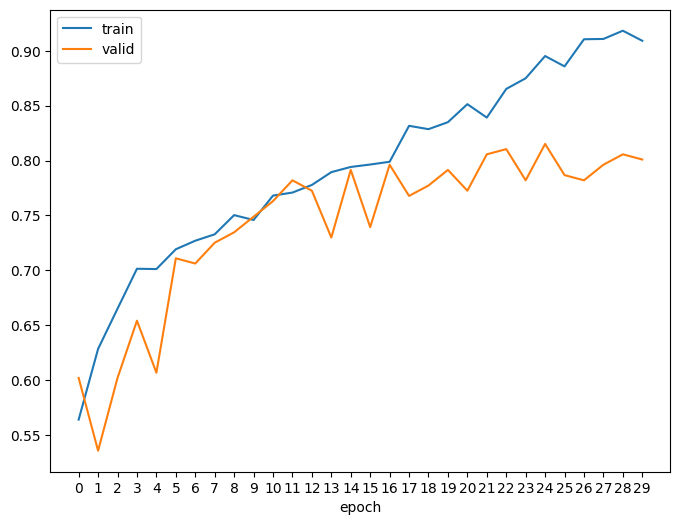

In [73]:
log = class_BCE_log

fig, ax = plt.subplots(figsize=(8,6))
xticks = range(log['epoch'].max()+1)
for type, df in log.groupby('type'):
    df.plot(x='epoch', y='accuracy', ax=ax, label=type, xticks=xticks);
plt.legend()

In [ ]:
torch.save(modelspath + '/class_resnet34_BCE.pth')

# Incorporating classification result


In [89]:
class CombinedModel(nn.Module):
    def __init__(self, seg_model, class_model, alpha=1):
        super().__init__()
        self.segmentation = torch.load(modelspath + '/' + seg_model)
        self.classification = torch.load(modelspath + '/' + class_model)
        self.alpha = alpha

    def forward(self, x):
        seg_output = self.segmentation(x)
        class_output = self.classification(x)
        #pdb.set_trace()
        return (class_output**self.alpha) * seg_output

In [85]:
test_model = CombinedModel(seg_model = 'resnet34_initial.pth', class_model = 'class_resnet34_BCE.pth')

In [86]:
test_log = predict_compare(valid_msks, test_model, color=True, preprocess=preprocess, metrics=[DiceLoss(soft=True), DiceLoss(soft=False)], device='cuda')

100%|██████████| 211/211 [00:04<00:00, 44.65it/s]


In [90]:
test_log.describe()

,soft_dice,hard_dice,gt_mask_size,pred_mask_size
count,211.000000,211.000000,211.000000,211.000000
mean,0.777721,0.251159,789.488152,623.668246
std,0.350609,0.380714,1021.357166,871.568074
min,0.063625,0.000000,0.000000,0.000000
25%,0.399285,0.000000,0.000000,0.000000
50%,0.999844,0.000000,0.000000,0.000000
75%,0.999998,0.319175,1815.500000,1490.000000
max,1.000000,1.000000,3720.000000,2528.000000


<Axes: xlabel='gt_mask_size', ylabel='pred_mask_size'>

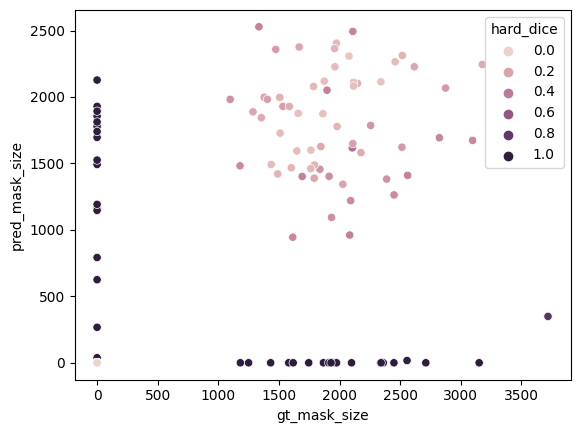

In [88]:
sns.scatterplot(data=test_log, x='gt_mask_size', y='pred_mask_size', hue='hard_dice')

# To-do List

0. Check the discrepancy between soft_dice and hard_dice.
1. Classification model can be improved.
2. Probability or {0,1}?
3. Classification and segmentation in one model instead of having two separate models.



# Definitions for cross-validation

In [ ]:
default_model_config = {'encoder_name':'resnet34',
                        'encoder_weights':'imagenet',
                        'activation':'sigmoid'}

In [ ]:
def create_smp_Unet(freeze_bottleneck=False, model_config=default_model_config):
    model = smp.Unet(**model_config)

    if freeze_bottleneck:
        # Let's assume encoder = resnet34 or resnet18
        for i, child in enumerate(model.encoder.layer4.children()):
            if i > 0:
                for param in child.parameters():
                    param.requires_grad = False

    return model

In [ ]:
def create_optim(model, proto=torch.optim.Adam, lr=1e-3):
    optim = proto([dict(params=model.parameters(), lr=lr)])
    return optim

In [ ]:
def load_cv_config(freeze_bottleneck=True):
    augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                    albumentations.HorizontalFlip()])

    preprocess_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
    preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                        albumentations.Lambda(image=preprocess_fn),
                                        albumentations.Lambda(image=to_tensor)])

    default_config = {'mskfiles': train_msks,
                      'augment': augment,
                      'preprocess': preprocess,
                      'model_gen': create_smp_Unet,
                      'optim_gen': create_optim,
                      'color': True,
                      'loss': DiceLoss(),
                      'metrics': [DiceLoss(), DiceLoss(soft=False)],
                      'device': 'cuda',
                      'batch_size': 16,
                      'epochs': 30,
                      'n_splits': 6,
                      'save_thres': 1e6, 'save_metric': 'hard_dice', 'save_path': None,
                      'stop_early': False
    }

    return default_config

In [ ]:
def cross_validate(mskfiles, augment, preprocess, model_gen=create_smp_Unet, optim_gen=create_optim,
                   color=True, loss=DiceLoss(), metrics=[DiceLoss(), DiceLoss(soft=False)],
                   device='cuda', batch_size=16, epochs=5, n_splits=8,
                   save_thres=1e6, save_metric='hard_dice', save_path=None, stop_early=False):

    stratify = [has_nerve(o) for o in mskfiles]
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True).split(mskfiles, stratify)

    columns = ['fold', 'epoch', 'type'] + [metric.__name__ for metric in metrics]
    loss_log = pd.DataFrame(columns=columns) # Save everything for now.
    for n, (train_idxs, valid_idxs) in enumerate(folds):
        print('\nFold: {}'.format(n))

        model = model_gen()
        optim = optim_gen(model)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

        train_msks, valid_msks = np.array(mskfiles)[train_idxs], np.array(mskfiles)[valid_idxs]

        valid_nerves = np.array([has_nerve(o) for o in valid_msks])
        valid_nerves, valid_no_nerves = np.where(valid_nerves>0), np.where(valid_nerves==0)
        nerve_ratio = len(valid_nerves[0])/len(valid_msks)
        valid_msks0, valid_msks1 = np.array(valid_msks)[valid_nerves], np.array(valid_msks)[valid_no_nerves]

        traindata = NerveDataset(mskfiles=train_msks, color=color, preprocess=preprocess, augment=augment)
        validdata0 = NerveDataset(mskfiles=valid_msks0, color=color, preprocess=preprocess)
        validdata1 = NerveDataset(mskfiles=valid_msks1, color=color, preprocess=preprocess)

        trainloader = DataLoader(traindata, batch_size = batch_size, shuffle = True)
        validloader0 = DataLoader(validdata0, batch_size = batch_size)
        validloader1 = DataLoader(validdata1, batch_size = batch_size)

        trainepoch = smp.utils.train.TrainEpoch(model, optimizer=optim, device=device, loss=loss, metrics=metrics, verbose=False)
        validepoch = smp.utils.train.ValidEpoch(model, device=device, loss=loss, metrics=metrics, verbose=False)

        if stop_early:
            stopper = EarlyStopper()

        for i in (epoch_bar := tqdm(range(epochs))):
            trainlogs = trainepoch.run(trainloader)
            validlogs0 = validepoch.run(validloader0)
            validlogs1 = validepoch.run(validloader1)

            train_loss = {'fold': n, 'epoch': i, 'type': 'train'}
            valid_loss0 = {'fold': n, 'epoch': i, 'type': 'valid_nerve'}
            valid_loss1 = {'fold': n, 'epoch': i, 'type': 'valid_no_nerve'}
            valid_loss = {'fold': n, 'epoch': i, 'type': 'valid'}

            train_loss.update(dict([(metric.__name__, trainlogs[metric.__name__]) for metric in metrics]))
            valid_loss0.update(dict([(metric.__name__, validlogs0[metric.__name__]) for metric in metrics]))
            valid_loss1.update(dict([(metric.__name__, validlogs1[metric.__name__]) for metric in metrics]))
            valid_loss.update(dict([(metric.__name__, (1-nerve_ratio)*validlogs0[metric.__name__]+ nerve_ratio*validlogs1[metric.__name__]) for metric in metrics]))

            loss_log.loc[len(loss_log)] = train_loss
            loss_log.loc[len(loss_log)] = valid_loss
            loss_log.loc[len(loss_log)] = valid_loss0
            loss_log.loc[len(loss_log)] = valid_loss1

            save_loss = (1-nerve_ratio)*validlogs0[save_metric]+ nerve_ratio*validlogs1[save_metric]
            if save_path is not None and valid_loss[save_metric] < save_thres:
                save_thres = save_loss
                torch.save(model, save_path)

            if stop_early:
                if stopper.early_stop(valid_loss[save_metric]):
                    print('Early stop triggered.')
                    break
                print(f'Valid Loss: {valid_loss[save_metric]:.4}, Stopper: min_validation_loss {stopper.min_validation_loss:.4}, counter {stopper.counter}.')

            lr_scheduler.step()

    return loss_log

# Adding a postprocessing layer

In [ ]:
class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module from https://gist.github.com/rwightman/f2d3849281624be7c0f11c85c87c1598

    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding

    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd,
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)

In [ ]:
nn.Sequential(
    nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.Identity(),
    nn.Sigmoid(),
    MedianPool2d(kernel_size=3, stride=2, padding=1)
)

Sequential(
  (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Sigmoid()
  (3): MedianPool2d()
)

In [ ]:
new_model = model
new_model.segmentation_head = nn.Sequential(
    nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.Identity(),
    nn.Sigmoid(),
    MedianPool2d(kernel_size=3, stride=1, padding=1)
)

In [ ]:
new_model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track